# Задача

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?


# Подготовка

Для решения задачи была использована библиотека pandas, библиотека seaborn для визуализации распределений, библиотека numpy для реализации ряда математических операций и библиотека scipy.stats для проведения теста Манна-Уитни. Кроме того, я установил питоновскую библиотеку bootstrapped для проведения Bootstrapa'а.

In [24]:
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import numpy as np

In [25]:
pip install bootstrapped

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/tljh/user/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

Для удобства я сразу поделил данные по обоим тестам на 2 датафрейма.

In [24]:
task_2 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-kobzev-24/shared/problem2.csv', sep=';')

# Здесь лежат контрольные данные.
task_a = task_2.query('testgroup == "a"') 

# Здесь лежат тестовые данные.
task_b = task_2.query('testgroup == "b"')

In [5]:
task_2.head(3)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a


Из первичного анализа я узнал, что подавляющее число пользователей в обоих группах не вносило денег в игру.

In [6]:
task_2.groupby('revenue').agg({'user_id': 'count'}).sort_values('user_id', ascending = False).head(3)

,user_id
revenue,
0,401037
310,18
206,18


# Выбираем метрики

Чтобы выбрать наиболее подходящую модель распространения внутриигровых товаров, я предлагаю посчитать ряд метрик по каждому из наборов, а также определить ряд значений:

    1) Суммарная прибыль – позволит мне сходу узнать о прибыльности обоих тестов;
    2) Минимальный доход с пользователя – узнать минимальную границу цен на товары, которые покупались;
    3) Максимальный – узнать максимальную границу цен на товары, которые покупались;
    4) 25 перцентиль по доходу – узнать примерный ценник на относительно дешевый товар;
    5) Медианный доход – узнать медианый ценник на товар;
    6) 75 перцентиль по доходу – узнать примерный ценник на относительно дорогой товар;
    7) ARPU – узнать средний доход по всем пользователям;
    8) ARPPU – узнать средний доход по всем платящим пользователям;
    9) Paying Conversion (конверсия в платеж) – узнать процент платящих пользователй относительно всех пользователей.
    
Я построю функцию calculations, которая сразу выдаст мне искомые значения по всем метрикам:

In [7]:
def calculations(a, b):
    
#   Суммарная прибыль
    suma = a.revenue.sum()
    sumb = b.revenue.sum()
    
#   Минимальный доход с человека
    mina = a.query('revenue != 0').revenue.min()
    minb = b.query('revenue != 0').revenue.min()
    
#   Максимальный доход с человека
    maxa = a.revenue.max()
    maxb = b.revenue.max()
    
#   25 перцентиль
    pera25 = np.percentile(a.query('revenue != 0').revenue, 25)
    perb25 = np.percentile(b.query('revenue != 0').revenue, 25)
    
#   Медианный доход с человека    
    meda = np.percentile(a.query('revenue != 0').revenue, 50)
    medb = np.percentile(b.query('revenue != 0').revenue, 50)

#   75 перцентиль
    pera75 = np.percentile(a.query('revenue != 0').revenue, 75)
    perb75 = np.percentile(b.query('revenue != 0').revenue, 75)
    
#   ARPU
    arpua = (a.revenue.sum() / a.user_id.nunique()).round(2)
    arpub = (b.revenue.sum() / b.user_id.nunique()).round(2)

#   ARPPU
    arppua = (a.revenue.sum() / a.query('revenue != 0').user_id.nunique()).round(2)
    arppub = (b.revenue.sum() / b.query('revenue != 0').user_id.nunique()).round(2)
    
#   Конверсия в платеж
    conva = np.round((a.query('revenue != 0').user_id.nunique() / a.user_id.nunique() * 100),2)
    convb = np.round((b.query('revenue != 0').user_id.nunique() / b.user_id.nunique() * 100),2)
    
#   Создаю словарь, из которого в итоге получится датафрейм с искомыми метриками.
    metrix = {'sum_revenue': [suma, sumb],
              'min_revenue': [mina, minb],
              'max_revenue': [maxa, maxb],
              '25_perc' :    [pera25, perb25],
              '50_perc' :    [meda, medb],
              '75_perc' :    [pera75, perb75],
              'arpu':        [arpua, arpub],
              'arppu':       [arppua, arppub],
              'paying_conv': [conva, convb]}  
    
#   Для удобства присваиваю значения 'a' и 'b' индексам датафрейма.              
    metrix = pd.DataFrame(metrix, index=['a', 'b'])
    
    return metrix

# Проверяем работоспособность функции calculations:

In [8]:
calculations(task_a, task_b)

,sum_revenue,min_revenue,max_revenue,25_perc,50_perc,75_perc,arpu,arppu,paying_conv
a,5136189,200,37433,257.0,311.0,361.0,25.41,2664.00,0.95
b,5421603,2000,4000,2513.0,3022.0,3478.0,26.75,3003.66,0.89


Разница между общей прибылью равна 285414р.

In [9]:
5421603 - 5136189

285414

Разница между ARPPU равна 11%.

In [10]:
100 - ((100 * 2664.00) / 3003.66)

11.30820399113081

Разница между конверсиями в платежи равна 6.

In [11]:
95 - 89

6

Перед выдвижением промежуточных выводов я хочу построить визуализацию, чтобы примерно понимать, как распределяется revenue.

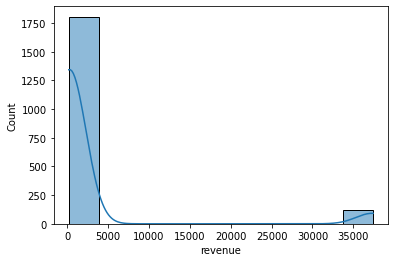

In [12]:
# Группа a
sns.histplot(task_a.query('revenue != 0').revenue, kde = True, bins=10)

Решил проверить, откуда в данном случае идет больше всего дохода: с больших платежей (revenue > 500р) или с маленьких (revenue < 500р).

Выяснилось, что с больших.

In [13]:
task_a.query('revenue != 0 and revenue < 500').revenue.sum()

545937

In [14]:
task_a.query('revenue != 0 and revenue > 500').revenue.sum()

4590252

Дополнительно я решил посмотреть на распределение revenue среди мелких платежей и крупных.

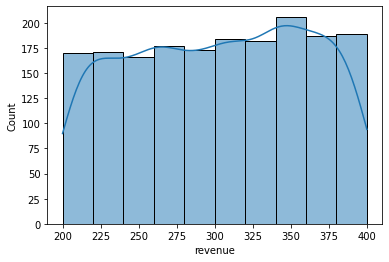

In [15]:
sns.histplot(task_a.query('revenue != 0 and revenue < 500').revenue, kde = True, bins=10)

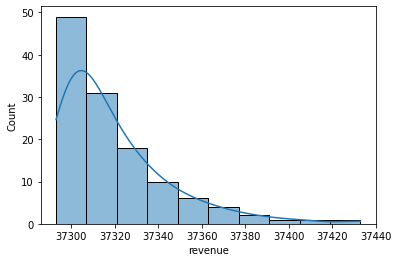

In [16]:
sns.histplot(task_a.query('revenue != 0 and revenue > 500').revenue, kde = True, bins=10)

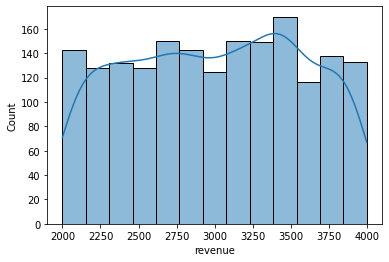

In [17]:
# Группа b
sns.histplot(task_b.query('revenue != 0').revenue, kde = True)

# Промежуточные итоги:

    1) Обе группы не имеют нормального распределения, что видно из визуализаций.
    2) В контрольной группе основной доход идет от крупных платежей, которые поступают куда реже мелких.
    3) В тестовой группе размах прибыли от игрока куда меньше, чем в контрольной.
    4) В тестовой группе каждый игровой набор покупается с относительно одинаковой частотой.
    5) В тестовой группе ARPPU выше на 11%.
    6) В контрольной группе конверсия в платежи выше на 0.06%.
    7) В тестовой группе общая прибыль выше на 285414р.
    
Основной вывод следующий:

Если в контрольной группе наборы продаются по мелкому и по крупному чеку, то в тестовой группе наборы продаются по среднему чеку. По этой причине в тестовой группе конверсия в продажи меньше, однако сами платежи стабильнее.

# Тесты

Я решил использовать тест Манна-Уитни, чтобы узнать, существует ли разница между контрольными и тестовыми данными.

Гипотезы у меня следующие:

    Н0 = распределение признака в первой выборке соответствует распределению признака во второй выборке.
    Н1 = распределение признака в первой выборке не соответствует распределению признака во второй выборке.

Для отклонения нулевой гипотезы p-value должен быть < 0.05

Проведем тест:

In [18]:
stats.mannwhitneyu(task_a.revenue, task_b.revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

Тест Манна-Уитни показывает, что верна нулевая гипотеза, однако тест был проведен по необработанным данным.

Я оставил в выборках данные по пользователям, которые не вложили деньги в игру.

Проведем еще один ранговый тест уже отсортировав указанных пользователей:

In [19]:
stats.mannwhitneyu(task_a.query('revenue != 0').revenue, task_b.query('revenue != 0').revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

В данном случае мы можем отклонить нулевую гипотезу, т.е. получается, что оба распределения статистически различаются.

Однако нам нужно узнать не о разнице между распределениями, а о прибыльности изменений.

Для этого мы используем Bootstrap.

Сперва проведем сравнение ARPU двух выборок, так как предположительно между ними есть значительная разница. Выведем следующие гипотезы:

    H0 = Значение параметра ARPU статистически равно в обоих выборках.
    H1 = Значение параметра ARPU статистически не равно в обоих выборках.
    
Для Bootstrap я взял 5000 выборок в размере 100 наблюдений в каждой. Доверительный интервал = 95%.

In [20]:
# Среднее

print(bs_compare.percent_change(task_b.revenue.mean(),
                                task_a.revenue.mean()))

print(bs.bootstrap_ab(np.array(task_b.revenue), 
                      np.array(task_a.revenue), 
                      bs_stats.mean,
                      bs_compare.percent_change,
                      num_iterations=5000,
                      alpha=0.05,
                      iteration_batch_size=100))

5.263168360069893
5.263168360069893    (-15.054389920261416, 20.661283225141617)


Выяснилось, что в данном случае не выйдет отклонить нулевую гипотезу, поскольку 0 не входит в доверительный интервал.

Предполагаю, что я столкнулся с ошибкой второго рода из-за избытка нулей в в выборке. Поэтому теперь я постараюсь испытать Bootstrap на параметре ARPPU.

Выведем следующие гипотезы:

    H0 = Значение параметра ARPPU статистически равно в обоих выборках.
    H1 = Значение параметра ARPPU статистически не равно в обоих выборках.

Для Bootstrap я взял 5000 выборок в размере 100 наблюдений в каждой. Доверительный интервал = 95%.

In [21]:
# Среднее без неплатящих пользователей

print(bs_compare.percent_change(task_b.query('revenue != 0').revenue.mean(),
                                task_a.query('revenue != 0').revenue.mean()))

print(bs.bootstrap_ab(np.array(task_b.query('revenue != 0').revenue), 
                      np.array(task_a.query('revenue != 0').revenue), 
                      bs_stats.mean,
                      bs_compare.percent_change,
                      num_iterations=5000,
                      alpha=0.05,
                      iteration_batch_size=100))

12.749997227996351
12.749997227996351    (-7.14009975522352, 27.834429095914235)


Выяснилось, что и в данном случае не выйдет отклонить нулевую гипотезу, поскольку 0 не входит в доверительный интервал.

Однако, как нам известно, распределения обоих выборок разительно отличаются. Поэтому я решил проверить медиану, чтобы обезапасить себя от ошибки второго рода из-за выбросов. 

В случае с медианой я сразу отфильтрую данные на предмет неплатящих пользователей. В противном случае функция будет показывать NaN-значения, т.к. из-за обилия нулей медиана в обоих группах будет равна 0.

Выведем следующие гипотезы:

    H0 = Значение параметра медиана статистически равно в обоих выборках.
    H1 = Значение параметра медиана статистически не равно в обоих выборках.

Для Bootstrap я взял 5000 выборок в размере 100 наблюдений в каждой. Доверительный интервал = 95%.

In [22]:
# Медиана без неплатящих пользователей

print(bs_compare.percent_change(task_b.query('revenue != 0').revenue.median(),
                                task_a.query('revenue != 0').revenue.median()))

print(bs.bootstrap_ab(np.array(task_b.query('revenue != 0').revenue), 
                      np.array(task_a.query('revenue != 0').revenue), 
                      bs_stats.median,
                      bs_compare.percent_change,
                      num_iterations=5000,
                      alpha=0.05,
                      iteration_batch_size=100))

871.7041800643087
871.7041800643087    (852.5281409992126, 892.6096380838891)


Наконец-то я могу отклонить нулевую гипотезу, так как ноль не входит в посчитанный доверительный интервал.

Таким образом мы можем сказать, что в тестовой группе доход действительно выше, чем в контрольной.



На всякий случай докажу, что без фильтрации проверка значения параметра медианы с помощью Bootstrap будет бессмыслена:

In [23]:
print(bs_compare.percent_change(task_b.revenue.median(),
                                task_a.revenue.median()))

print(bs.bootstrap_ab(np.array(task_b.revenue), 
                      np.array(task_a.revenue), 
                      bs_stats.median,
                      bs_compare.percent_change,
                      num_iterations=5000,
                      alpha=0.05,
                      iteration_batch_size=100))

nan


/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-kobzev-24/.local/lib/python3.7/site-packages/bootstrapped/compare_functions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  return (test_stat - ctrl_stat) * 100.0 / ctrl_stat


nan    (nan, nan)


/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-kobzev-24/.local/lib/python3.7/site-packages/bootstrapped/compare_functions.py:33: RuntimeWarning: invalid value encountered in true_divide
  return (test_stat - ctrl_stat) * 100.0 / ctrl_stat


# Выводы

Я предлагаю использовать тестовую модель распространения товара, поскольку она обладает следующими преимуществами:

1) В тестовой выборке метрики ARPU и ARPPU оказались выше.

2) Тестовая выборка предлагает более стабильный вариант распространения товара. Все товары в тестовой группе продаются более менее равномерно (что видно исходя из визуализации распределение revenue).
    
3) Создателям игры будет легче править ее баланс и экономику, т.к. в тестовом варианте пользователям предлагается покупать товары примерно одной ценовой категории (от 2000р до 4000р).